# Practical Assignment 6
#### *Submitted by Mukul Aryal (CS IV/I)*
##### Implementing CNN in TensorFlow

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import tensorflow.compat.v1 as tf
tf.logging.set_verbosity(tf.logging.ERROR)
tf.disable_eager_execution()
import matplotlib.pyplot as plt
%matplotlib inline

2025-05-15 14:45:32.370543: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-15 14:45:32.371664: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-15 14:45:32.379013: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-15 14:45:32.400143: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747299632.436257   37404 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747299632.44

In [2]:
# load mnist dataset
mnist = tf.keras.datasets.mnist

In [3]:
# define helper functions
def initialize_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.1))

def initialize_bias(shape):
    return tf.Variable(tf.constant(0.1, shape=shape))

def convolution(x, W):
    return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='SAME')

def max_pooling(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

In [4]:
# placeholder input and output

#input image
X_ = tf.placeholder(tf.float32, [None, 784])

# reshaped input image
X = tf.reshape(X_, [-1, 28, 28, 1])

# output label
y = tf.placeholder(tf.float32, [None, 10])

In [5]:
# Define convolution network
W1 = initialize_weights([5,5,1,32])
b1 = initialize_bias([32])
conv1 = tf.nn.relu(convolution(X, W1) + b1)
pool1 = max_pooling(conv1)

# second convolution layer
W2 = initialize_weights([5,5,32,64])
b2 = initialize_bias([64])
conv2 = tf.nn.relu(convolution(pool1, W2) + b2)
pool2 = max_pooling(conv2)

# flatten output
flattened = tf.reshape(pool2, [-1, 7*7*64])
# fully connected layer
W_fc = initialize_weights([7*7*64, 1024])
b_fc = initialize_bias([1024])
fc_output = tf.nn.relu(tf.matmul(flattened, W_fc) + b_fc)

# output layer
W_out = initialize_weights([1024, 10])
b_out = initialize_bias([10])
y_hat = tf.nn.softmax(tf.matmul(fc_output, W_out) + b_out)

In [6]:
# cost function
cross_entropy = -tf.reduce_sum(y*tf.log(y_hat))
# optimizer
optimizer = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
# accuracy
predicted_digit = tf.argmax(y_hat, 1)
actual_digit = tf.argmax(y, 1)

correct_pred = tf.equal(predicted_digit,actual_digit)
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [7]:
# custom function to batch the data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

# Normalize data
x_train = x_train / 255.0
x_test = x_test / 255.0

def next_batch(batch_size):
    idx = np.random.choice(len(x_train), batch_size, replace=False)
    return x_train[idx].reshape(-1, 784), y_train[idx]

In [8]:
# start training

sess = tf.Session()
sess.run(tf.global_variables_initializer())

for epoch in range(1000):
    batch_x, batch_y = next_batch(100)
    sess.run(optimizer, feed_dict={X_: batch_x, y: batch_y})
    if epoch % 100 == 0:
        train_accuracy = sess.run(accuracy, feed_dict={X_: batch_x, y: batch_y})
        print("Epoch:", epoch, "Training accuracy:", train_accuracy)

2025-05-15 14:45:38.936248: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
I0000 00:00:1747299638.949407   37404 mlir_graph_optimization_pass.cc:425] MLIR V1 optimization pass is not enabled


Epoch: 0 Training accuracy: 0.14
Epoch: 100 Training accuracy: 0.89
Epoch: 200 Training accuracy: 0.95
Epoch: 300 Training accuracy: 0.93
Epoch: 400 Training accuracy: 0.96
Epoch: 500 Training accuracy: 0.97
Epoch: 600 Training accuracy: 0.97
Epoch: 700 Training accuracy: 0.99
Epoch: 800 Training accuracy: 0.99
Epoch: 900 Training accuracy: 0.97


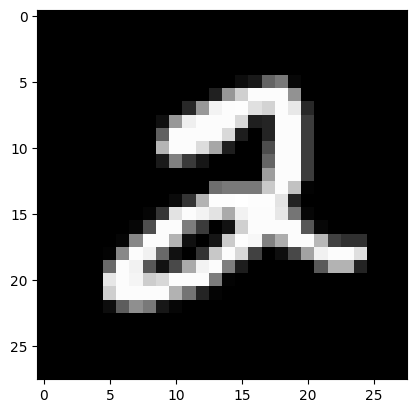

In [9]:
# visualize extracted features
plt.imshow(x_train[5], cmap='gray')

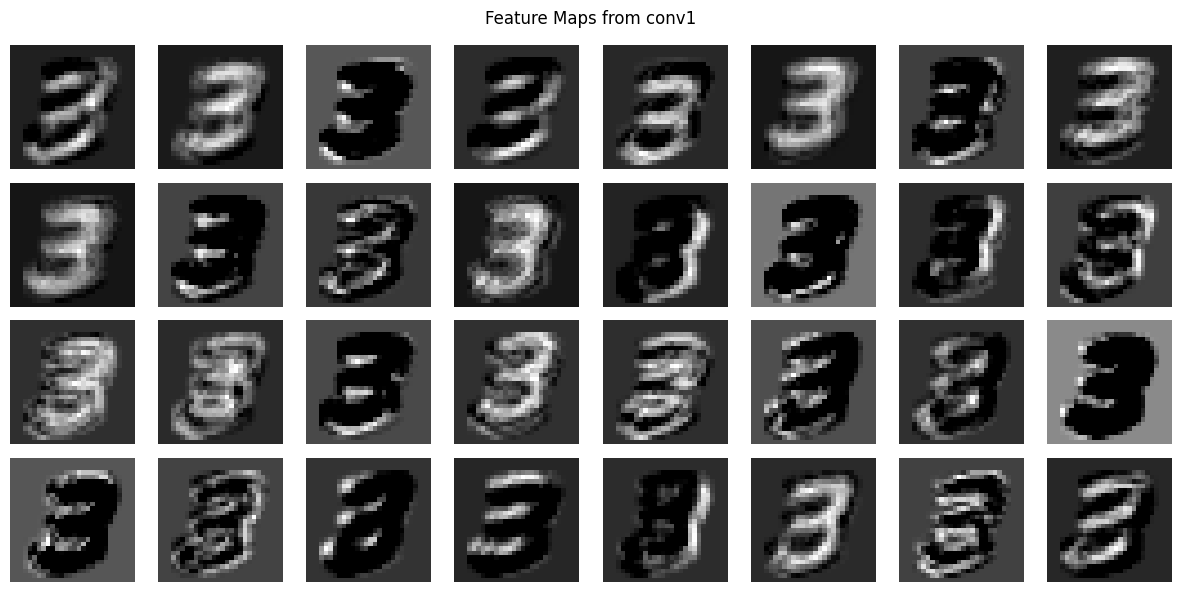

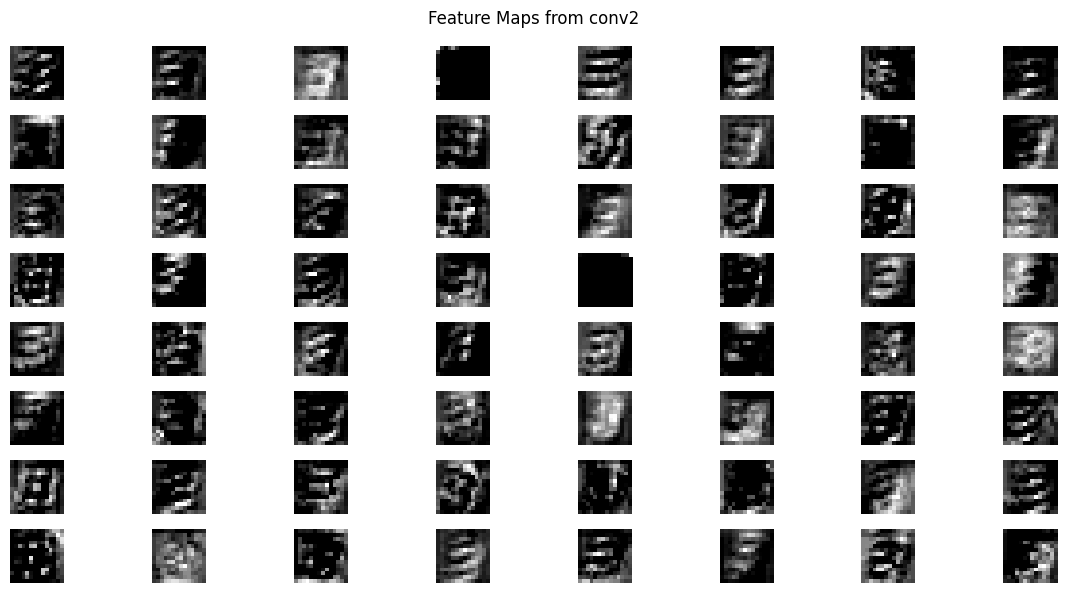

In [10]:
image = x_train[7].reshape(1, 784)  # batch size 1

# Run convolution layers to get feature maps
feature_map1 = sess.run(conv1, feed_dict={X_: image})  # shape: [1, 28, 28, 32]
feature_map2 = sess.run(conv2, feed_dict={X_: image})  # shape: [1, 14, 14, 64]

# Plot feature maps from conv1
plt.figure(figsize=(12, 6))
plt.suptitle("Feature Maps from conv1")
for i in range(32):
    feature = feature_map1[0, :, :, i]  # shape (28, 28)
    plt.subplot(4, 8, i + 1)
    plt.imshow(feature, cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

# Plot feature maps from conv2
plt.figure(figsize=(12, 6))
plt.suptitle("Feature Maps from conv2")
for i in range(64):
    feature = feature_map2[0, :, :, i]  # shape (14, 14)
    plt.subplot(8, 8, i + 1)
    plt.imshow(feature, cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()